# Data Cleaning and Visualisation to Give Insights Into Cancelling Clients

Our subcription based pricing model means we are exposed to clients cancelling their payments. Therefore, we first want to understand more about who our cancelling clients are; what is our rate of cancellation? What year is a client most likely to cancel? Does the sector or type of client or the amount a client pays tell us if they are more likely to cancel? These are the types of questions we answer here by cleaning our datasets and slicing the data in different ways.

Please note that all data has been anonymised.



# 1. Import Libaries

Below we are importing all the Python libraries we will need for this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.gridspec import GridSpec

plt.style.use('fivethirtyeight')
%matplotlib inline
palette = itertools.cycle(sns.color_palette())

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

# 2. Import Data

In [2]:
# Reading in the csv

columns = ['customerid','client_status','account_status','customer_name','customer_type','value','year_of_current_deal','cancellation_timing','sector','cancellation_reason']
renewals = pd.read_csv('~/Documents/portfolio/datasets/Renewal-Cancelation Book Anonymised3.csv', names=columns, header=0)
renewals.sample(5)

,customerid,client_status,account_status,customer_name,customer_type,value,year_of_current_deal,cancellation_timing,sector,cancellation_reason
431,1975,Mid,Active,238,One,2000,2,NaN,Freelancer,NaN
655,86,High,Active,188,Three,5039,5,NaN,Financials,NaN
563,190,Mid,Active,966,Two,3500,5,NaN,Energy,NaN
271,2200,High,Active,1001,Two,6000,1,NaN,General,NaN
1135,1824,High,Active,709,Two,4950,2,NaN,Travel & Leisure,NaN


Importing the renewal data we have the following variables:

In [3]:
renewals.dtypes # types of data

customerid               int64
client_status           object
account_status          object
customer_name            int64
customer_type           object
value                    int64
year_of_current_deal     int64
cancellation_timing     object
sector                  object
cancellation_reason     object
dtype: object

To give a description of each variable:

<br>

<b>customerid</b> : 
a unique identifier for each account that will be used to join additional datasets later on 

<b>client_status</b> : 
a grading system of the account given by the account manager that denotes the level of usage and engagement, high means no cause for concern as high engagement and usage and low means little/no usage and engagement, high risk of cancellation.

<b>account_status</b> : 
denotes whether the client is active (paying customer) or inactive (cancelled)

<b>customer_name</b> : 
customer number     

<b>customer_type</b> : 
we categorise into three pots of client according to size in revenue; one being the smallest, and three being the largest.

<b>value</b> : 
the current price of subscription, there are three types of subcription for which the prices differ and this is dependent on the customer type.

<b>year_of_current_deal</b> : 
the year of maturity of the account

<b>cancellation_timing</b> : 
shows if the cancellation was at the start of a period or mid way through

<b>sector</b>: 
the industry that the customer operates in 

<b>cancellation_reason</b> : 
a reason for cancellation picked from a preset list of reasons

# 3. Exploratory Data Analysis (EDA) Part 1 - For Data Cleaning

In this section we will clean the initial dataset. 

In [4]:
# To give an idea of the size of the initial data set (rows, columns)

renewals.shape

(1152, 10)

In [5]:
# Dropping any unwanted columns. 

renewals.drop(columns=['cancellation_timing'],
              inplace=True)

In [6]:
# Identifing null values

renewals.isnull().sum()

customerid                0
client_status            18
account_status            0
customer_name             0
customer_type             0
value                     0
year_of_current_deal      0
sector                    0
cancellation_reason     899
dtype: int64

In [7]:
# Indentifying the rows of the null values in client status

renewals[renewals['client_status'].isnull()].any(axis=1)

44      True
47      True
329     True
330     True
334     True
336     True
464     True
603     True
613     True
883     True
912     True
920     True
935     True
967     True
997     True
1037    True
1060    True
1097    True
dtype: bool

In [8]:
# We can fill these client status' in with 'Unknown' 

renewals['client_status'].fillna('Unknown', inplace = True)

In [9]:
# Checking that the previous null values are filled as expected

renewals.loc[44]

customerid                             228
client_status                      Unknown
account_status                    Inactive
customer_name                           91
customer_type                        Three
value                                 4000
year_of_current_deal                     2
sector                          Financials
cancellation_reason     No longer required
Name: 44, dtype: object

In [10]:
# Exploring the client status shows us that most of the accounts are/were high engagement, however we should merge 
# the two high categories that are a result of differing cases.

renewals['client_status'].value_counts()

Mid        527
High       482
Low         75
high        50
Unknown     18
Name: client_status, dtype: int64

In [11]:
# Cleaning the two 'high' categories 

renewals['client_status'] = renewals['client_status'].replace({'high': 'High'}) # map the two using a dictionary
renewals['client_status'].value_counts()

High       532
Mid        527
Low         75
Unknown     18
Name: client_status, dtype: int64

In [12]:
# Checking how many cancelled customers have a missing value in cancellation reason

cancelled_filter = renewals['account_status'] == 'Inactive' # creating a filter
cancelled = renewals[cancelled_filter] # saving a smaller subset of just cancelled clients
cancelled[cancelled['cancellation_reason'].isnull()].any(axis=1) # identifying the rows within the cancelled subset that are missing a cancelation reason

163    True
263    True
737    True
870    True
dtype: bool

In [13]:
# filling in the cancellation reason of the 4 cancelled accounts with 'Reason Unknown'

renewals.at[163, 'cancellation_reason'] = 'Reason Unknown'
renewals.at[263, 'cancellation_reason'] = 'Reason Unknown'
renewals.at[737, 'cancellation_reason'] = 'Reason Unknown'
renewals.at[870, 'cancellation_reason'] = 'Reason Unknown'

In [14]:
# checking it has been filled in

renewals.loc[163]

customerid                        1372
client_status                      Low
account_status                Inactive
customer_name                      517
customer_type                      Two
value                             4950
year_of_current_deal                 1
sector                      Financials
cancellation_reason     Reason Unknown
Name: 163, dtype: object

In [15]:
# Checking for duplicate entries for clients

renewals.customer_name.value_counts()

569     2
1151    1
386     1
380     1
381     1
       ..
768     1
769     1
770     1
771     1
1       1
Name: customer_name, Length: 1151, dtype: int64

In [16]:
# locating the rows of the duplicate accounts and checking both rows have the same information before deleting one

duplicate_name = renewals.customer_name == 569
renewals[duplicate_name]

,customerid,client_status,account_status,customer_name,customer_type,value,year_of_current_deal,sector,cancellation_reason
173,1490,Mid,Inactive,569,Two,10500,1,General,Switched to competitor
174,1490,Mid,Inactive,569,Two,10500,1,General,Switched to competitor


In [17]:
# Deleting the one duplicate row

renewals.drop(renewals.index[173], inplace = True)

In [18]:
# Checking there are no more duplications

renewals.customer_name.value_counts()

1151    1
386     1
380     1
381     1
382     1
       ..
768     1
769     1
770     1
771     1
1       1
Name: customer_name, Length: 1151, dtype: int64

In [19]:
# Checking cancellation reason to see what the options are and if it needs cleaning

renewals.cancellation_reason.value_counts()

No longer required              132
Switched to competitor           61
Insufficient Funds               34
Data Quality                     12
Low engagement                    5
Merged with exsisting client      4
Reason Unknown                    4
Data quality                      2
We terminated contract            2
Name: cancellation_reason, dtype: int64

In [20]:
# Combining the two 'data quality' buckets 

renewals['cancellation_reason'] = renewals['cancellation_reason'].replace({'Data Quality': 'Data quality'})
renewals['cancellation_reason'].value_counts()

No longer required              132
Switched to competitor           61
Insufficient Funds               34
Data quality                     14
Low engagement                    5
Merged with exsisting client      4
Reason Unknown                    4
We terminated contract            2
Name: cancellation_reason, dtype: int64

In [21]:
renewals['account_status'].value_counts()

Active      895
Inactive    256
Name: account_status, dtype: int64

In [22]:
# Checking the final shape of the dataset after cleaning

renewals.shape

(1151, 9)

# EDA Part 2 - Feature Analysis

Now we have cleaned our dataset we will use visualisations to explore the variables further.

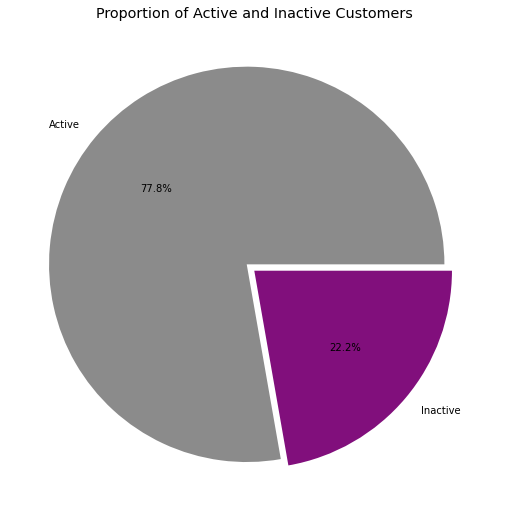

In [25]:
# Visualising the proportion of active and inactive accounts.

source_labels = renewals.account_status.sort_values().index
source_counts = renewals.account_status.value_counts()
labels = 'Active','Inactive'
colors = palette
explode = (0.05, 0) # exploding the smaller section from the circle 

plt.figure(1, figsize=(40,20))
the_grid = GridSpec(2, 2)


plt.subplot(the_grid[0, 1], aspect=1, title='Proportion of Active and Inactive Customers')
source_pie = plt.pie(source_counts, autopct='%1.1f%%', labels = labels, explode = explode, colors=colors)
plt.show()


In our 6 years of operating only 22.2% of our total customers have cancelled.

Let's explore this further by looking at active and inactive clients by year. From the below bar chart we can see that we are at the highest risk of losing the most clients in year 1. From year 1 to year 2 our number of cancelled clients drops to under a quarter of that in year 1. Beyond year 3 our churn rate is close to 0, and so when looking at our current live clients by year we will want to renew as many clients as possible through years 1, 2 and 3 to reduce the risk of losing them in the future. 

[Text(0, 0.5, 'Count of Clients'), Text(0.5, 0, 'Year of Deal')]

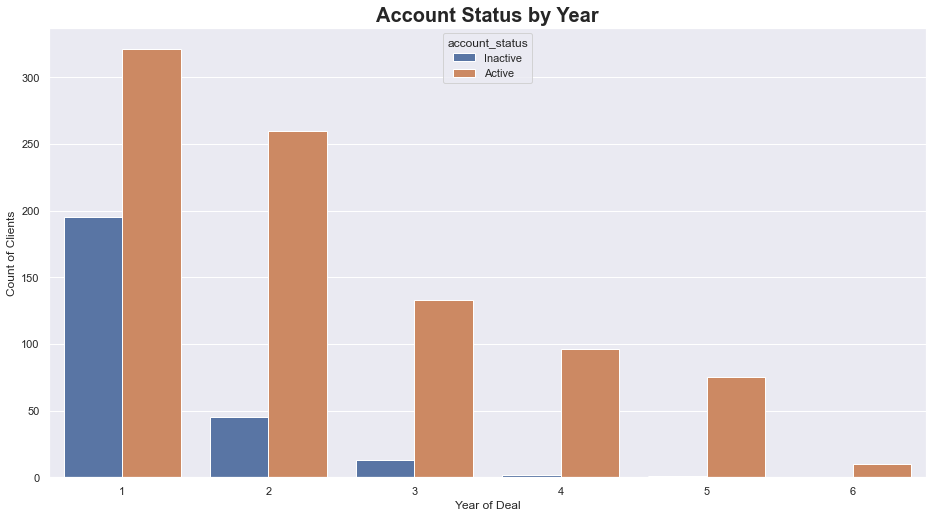

In [32]:
# Active and inactive customers by year

renewals.sort_values(('year_of_current_deal'), inplace = True)
sns.set(rc={'figure.figsize':(14,8.27)})
ax = sns.countplot(x="year_of_current_deal", hue="account_status", data=renewals)
ax.set_title('Account Status by Year', fontsize =20, weight = 'bold')
ax.set(xlabel='Year of Deal', ylabel='Count of Clients')

Let's build on this insight and explore the client status.

High    491
Mid     381
Low      23
Name: client_status, dtype: int64

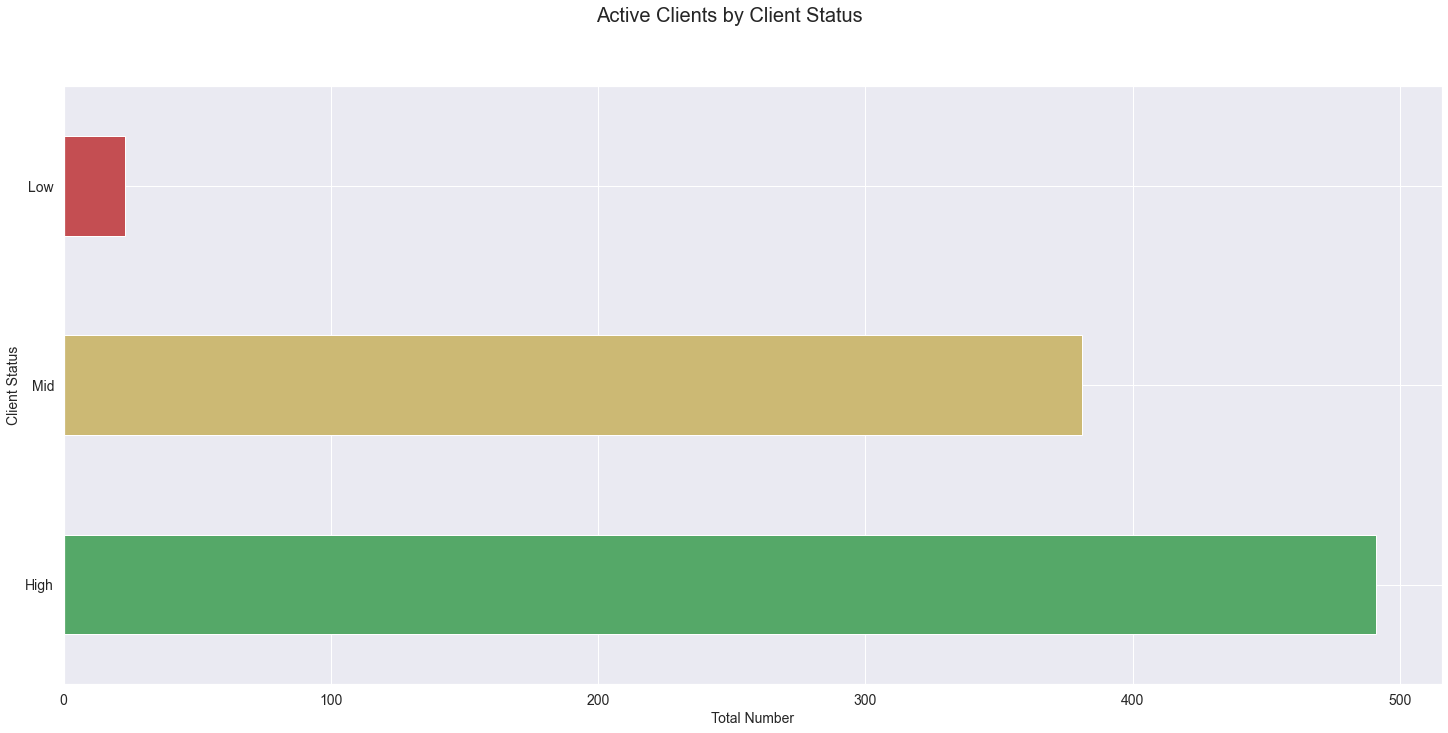

In [33]:
# Creating a horizontal bar graph to show the number of active clients by account status.

live_mask = renewals[renewals['account_status']=='Active'] # a mask of the dataset to only include active clients
live_mask['client_status'].value_counts().plot(
    kind = 'barh', 
    x = 'Number of Clients', 
    y = 'Client Status', 
    fontsize = 14, 
    color = (['g', 'y', 'r']),
    figsize = (22,11) 
)

plt.xlabel('Total Number', fontsize = 14);
plt.ylabel('Client Status', fontsize = 14);
plt.suptitle('Active Clients by Client Status', fontsize=20);

live_mask['client_status'].value_counts()

Straight away we can see that the majority (55%) of our active customers are considered to have high engagement and usage by our Account Managers. In addtion, the Account Managers also identify 23 live accounts as high risk of cancelling, only 2.6% of total live customers. There are 42.6% of active customers that have a medium level of engagement and usage. By default when we win a client the client status is put to 'mid' until the Account Manager has trained the new users and has a better idea of engagement. With this in mind and that we are growing 24% year on year it is unsurprising that the number of 'mid' accounts is high. 

Mid        145
Low         52
High        41
Unknown     18
Name: client_status, dtype: int64

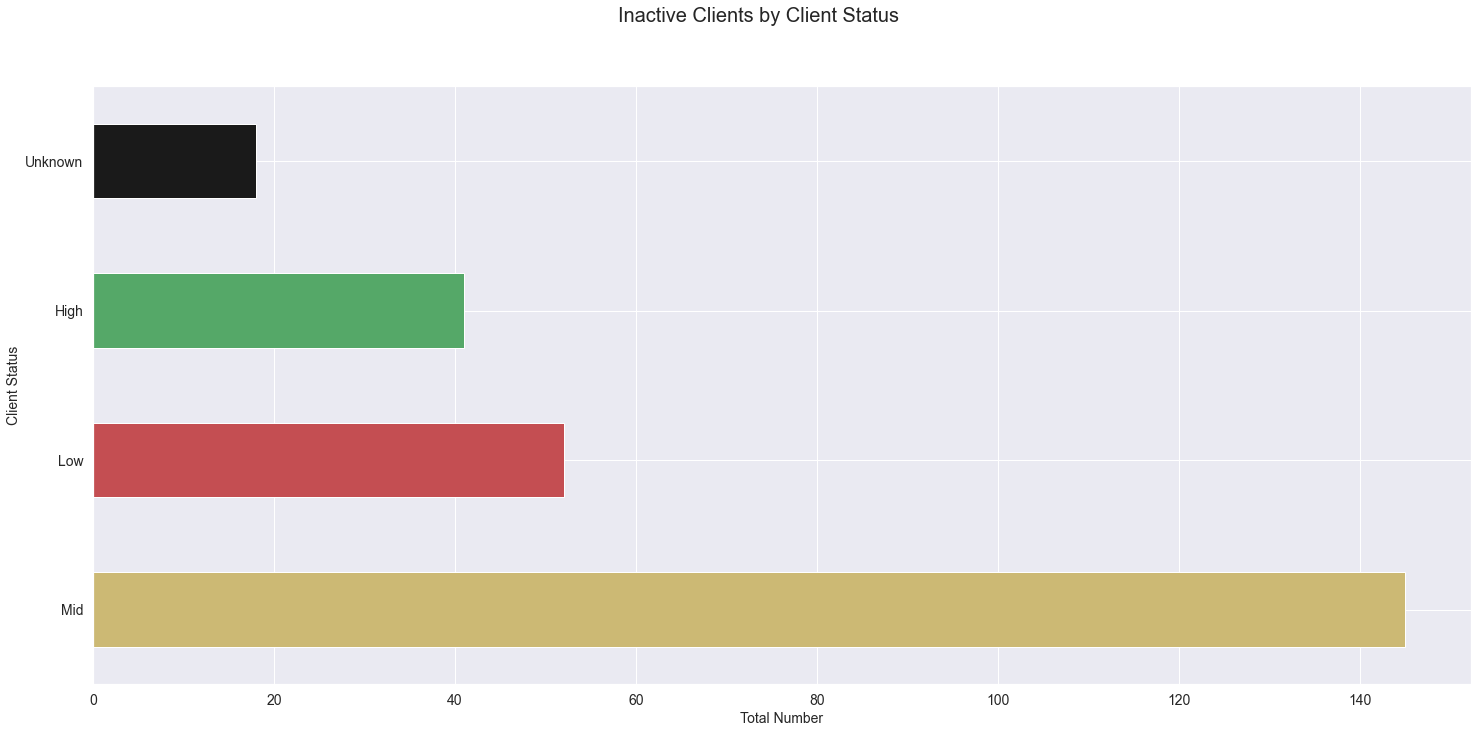

In [34]:
# Looking at the same as above but for cancelled clients

cancelled_mask = renewals[renewals['account_status']=='Inactive'] # a mask to only include inactive clients
cancelled_mask['client_status'].value_counts().plot(
    kind = 'barh', 
    x = 'Number of Clients', 
    y = 'Client Status', 
    fontsize = 14, 
    color = (['y','r','g','k']),
    figsize = (22,11) 
)

plt.xlabel('Total Number', fontsize = 14);
plt.ylabel('Client Status', fontsize = 14);
plt.suptitle('Inactive Clients by Client Status', fontsize=20);

cancelled_mask['client_status'].value_counts()

Now we can see that cancelled clients sit within all the status options and being in the high engagement category doesn't necessarily mean the client isn't at risk of cancelling. However, the chances are much lower. The chart tells us that the highest risk of cancellation is when the client's status is 'Mid' by more than double that of any other status (57% of all cancelled clients). Low engagement and usage customers account for 20% of cancelled customers, high engagement and usage makes up 16% and 7% of inactive customers have an unknown status.


This insight coupled with the fact there are 42.6% of active clients currently cateogised as 'Mid' means we need to consider the factors that influence a client to cancel. Given that we know 'Mid' is the automatic status given to any new client it would be interesting to now look at the status distribution amongst live and cancelled clients in different years.

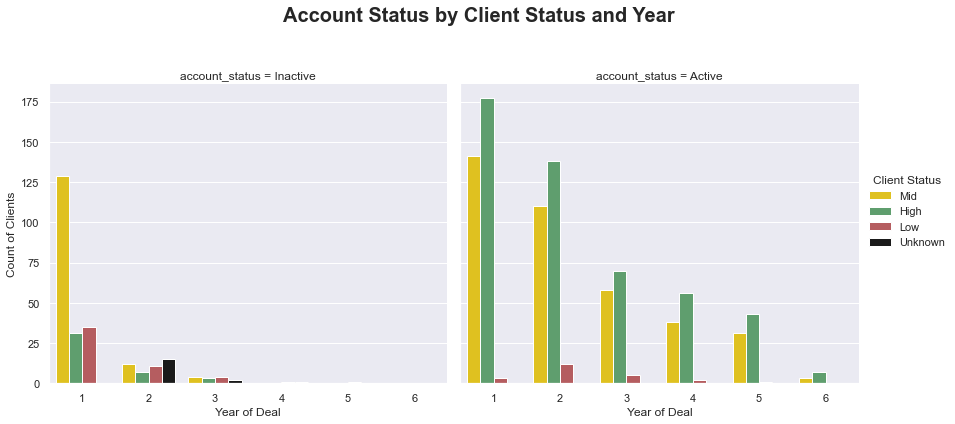

In [35]:
# Two plots (inactive and active clients) by status and year 

trafficlight = {'Mid': 'gold',
               'High': 'g',
               'Low': 'r',
               'Unknown': 'k'}

renewals.sort_values(('year_of_current_deal'), inplace = True)

g = sns.catplot(x="year_of_current_deal", hue="client_status", col="account_status", 
                data=renewals, kind="count",
                height=6, aspect=1, palette = trafficlight)


# Using hue to differentiate between client status in the columns

(g.set_axis_labels("Year of Deal", "Count of Clients"))

# Set title of legend
new_title = 'Client Status'
g._legend.set_title(new_title)

    
g.fig.suptitle('Account Status by Client Status and Year', weight='bold', fontsize=20)

plt.subplots_adjust(top=0.8)
    

The stand out here is the large number of year 1 'Mid' status clients. An inital observation may be that the reason for the higher number of 'Mid' clients that cancelled in year 1 compared to other years may just be a product of our internal automation of new clients being denoted as 'Mid'. As the number of 'Mid' clients cancelling in year 2 looks to drop way in line with those of 'Low' status. The general pattern is 'Mid' and 'High' clients are the highest cancellations each year, which tells us that our metric given by Account Managers is a helpful one.

The plot above pulls together everything that we have learnt so far. The majority of our clients are active and we are at highest risk of losing 'mid' status clients in year 1. Beyond year 1 the risk decreases for all client status', with only 3 clients getting to year 4 or more and cancelling (1.2% of cancelled clients). Given the high numbers of active 'Mid' clients we have in the right plot we need to find an effective way of understanding which clients will cancel as looking at client status and year gives us some insight but let's see if we can do better.

Now let's take a look at the customer types.

In [36]:
# The number of active clients by type

print('Active clients by type: ')
live_mask['customer_type'].value_counts()

Active clients by type: 


Three    515
Two      283
One       97
Name: customer_type, dtype: int64

In [37]:
# The number of inactive clients by type

print('Inactive clients by type:')
renewals['customer_type'].value_counts() - live_mask['customer_type'].value_counts()

Inactive clients by type:


Three    138
Two       74
One       44
Name: customer_type, dtype: int64

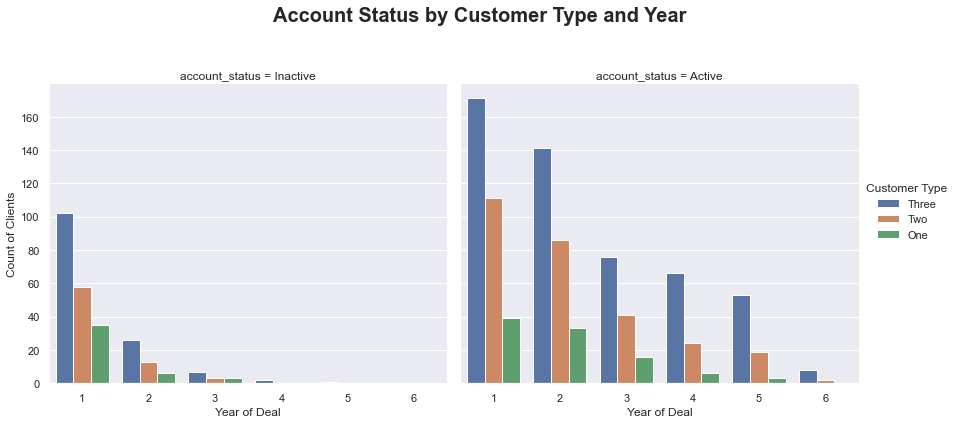

In [147]:
# Two plots (inactive and active clients) by type and year 

renewals.sort_values(('year_of_current_deal'), inplace = True)

g = sns.catplot(x="year_of_current_deal", hue="customer_type", col="account_status", 
                data=renewals, kind="count",
                height=6, aspect=1);

# Using hue to differentiate between customer types in the columns

(g.set_axis_labels("Year of Deal", "Count of Clients"))

# Set title of legend
new_title = 'Customer Type'
g._legend.set_title(new_title)

# Replace labels on legend
new_labels = ['Three', 'Two','One']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l);
    
g.fig.suptitle('Account Status by Customer Type and Year', weight='bold', fontsize=20)

plt.subplots_adjust(top=0.8)

Here we can see that the majority of our clients are larger entities, medium sized and and then small businesses. The numbers of inactive customers also follow this pattern.

Now let's take a look at the value of clients.

In [148]:
# Descriptive statistics of the numerical values

# Minimum value
minimum_value = np.min(renewals.value)

# Maximum value
maximum_value = np.max(renewals.value)

# Mean value
mean_value = np.mean(renewals.value)

# Median value
median_value = np.median(renewals.value)

# Standard deviation value
std_value = np.std(renewals.value)

# Show the calculated statistics
print ('Statistics for value:\n')
print('Minimum value: £{:,.2f}'.format(minimum_value))
print ('Maximum value: £{:,.2f}'.format(maximum_value))
print ('Mean value: £{:,.2f}'.format(mean_value))
print ('Median value £{:,.2f}'.format(median_value))
print ('Standard deviation of values: £{:,.2f}'.format(std_value))

Statistics for value:

Minimum value: £375.00
Maximum value: £20,890.00
Mean value: £4,417.48
Median value £4,750.00
Standard deviation of values: £1,585.47


When we consider the descriptive statistics of the value, we can see the maximum shows an outlier of £20,890 likely to be a large corporation on a higher tier of users, compared to the minimum value which is an account with one user. 

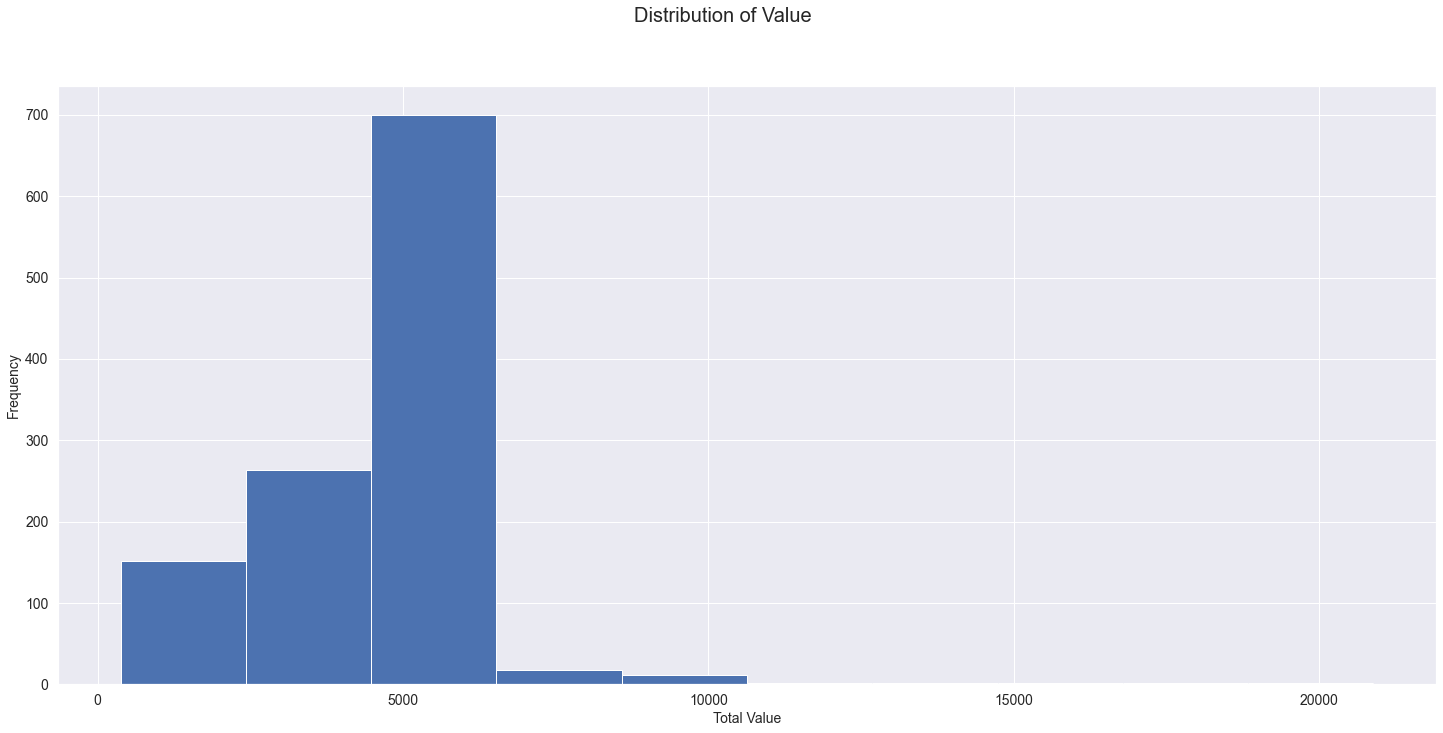

In [38]:
# Histogram to show distribution of value. 

renewals.value.plot(kind='hist', bins=10,fontsize=14,  figsize = (22,11) );
plt.xlabel('Total Value', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.suptitle('Distribution of Value', fontsize=20);

ADD

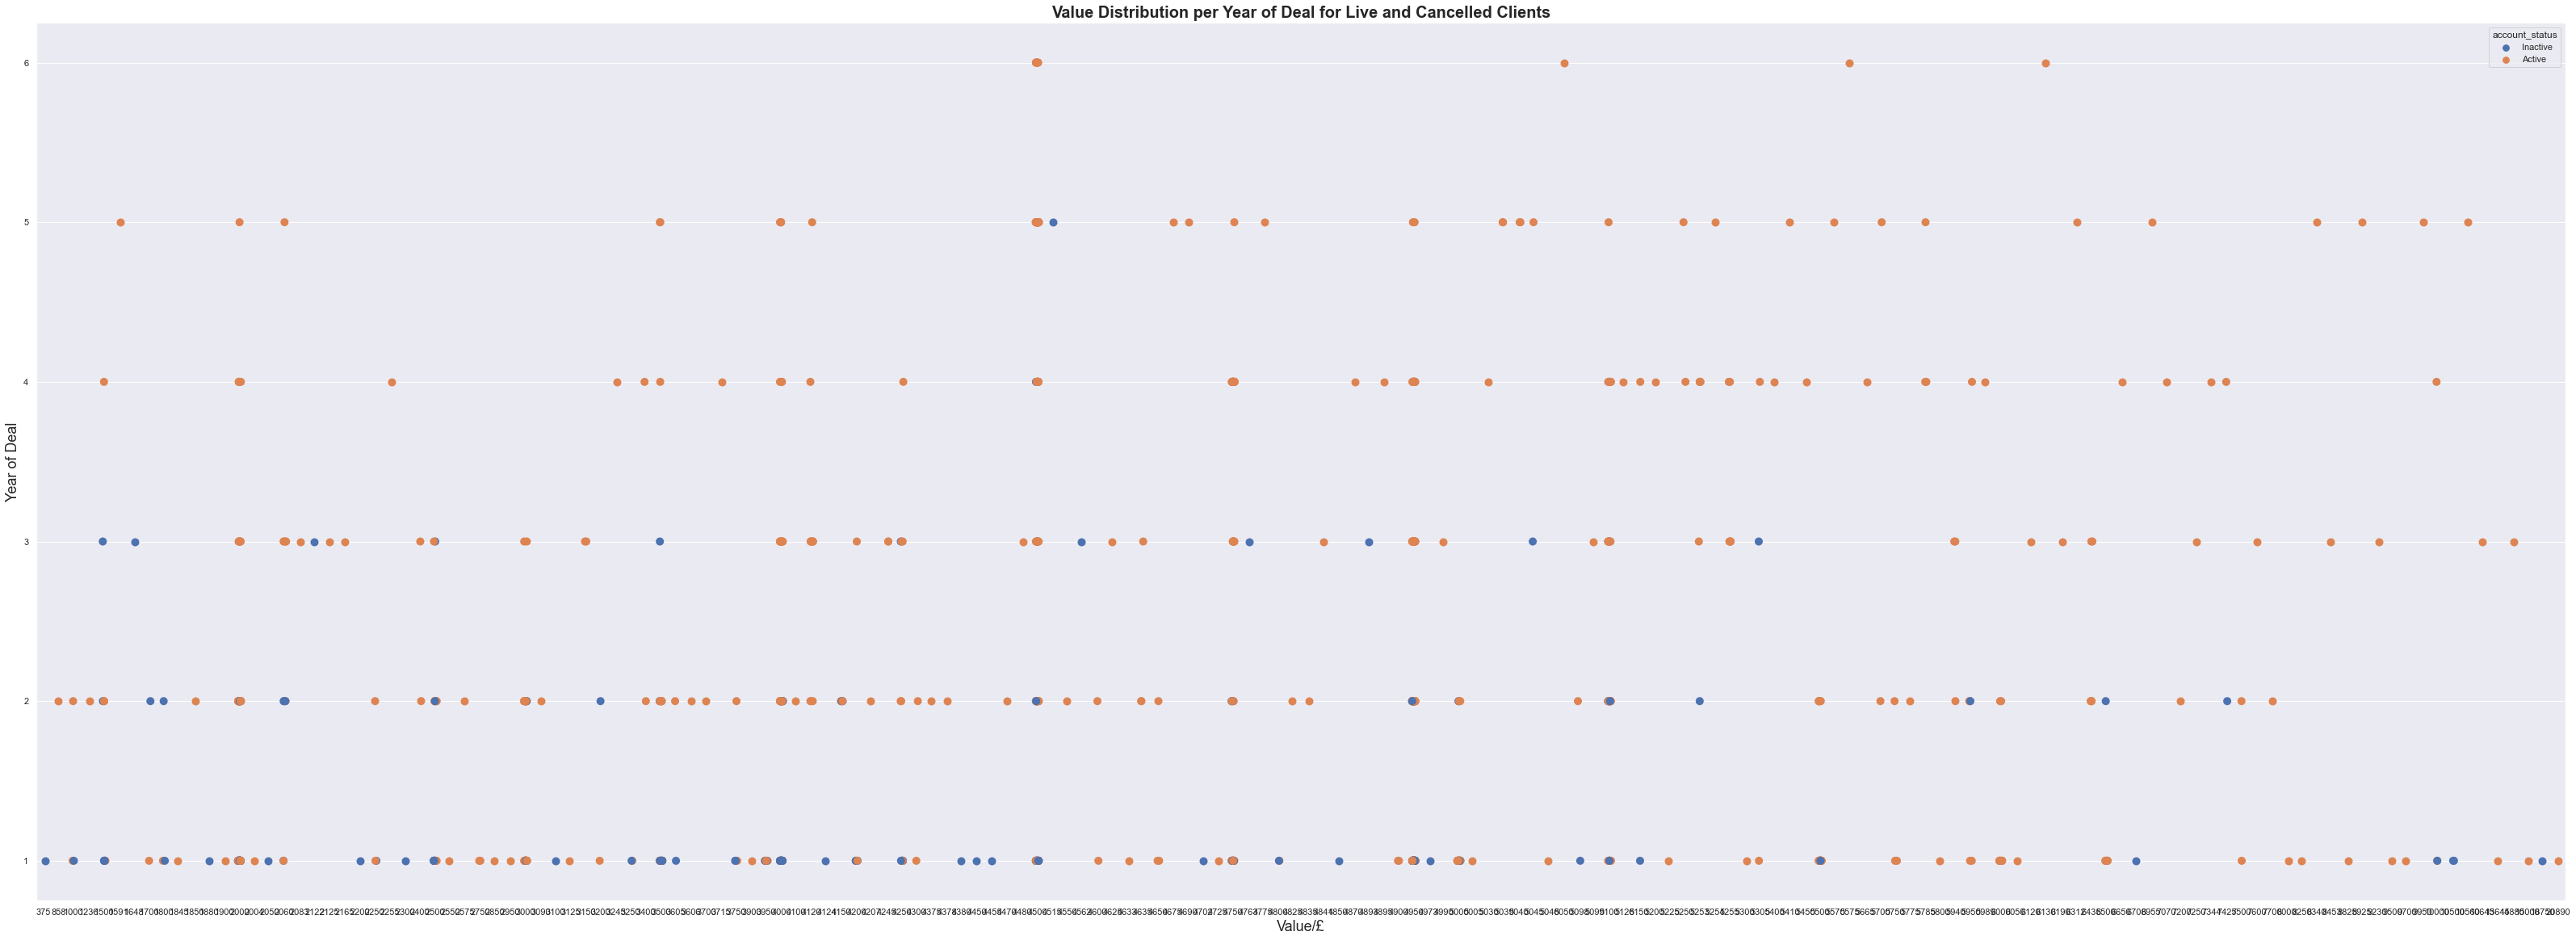

In [39]:
# Seaborn Strip plot showing the distribution of value per year of deal comparing both live and cancelled clients

sns.set(rc={'figure.figsize':(50,20)}) 

ax = sns.stripplot(x=renewals['value'], y=renewals['year_of_current_deal'].sort_values(), hue = renewals['account_status'], size=10)
ax.set_title('Value Distribution per Year of Deal for Live and Cancelled Clients', fontsize=20, weight='bold')
ax.set_xlabel('Value/£',fontsize=18)
ax.set_ylabel('Year of Deal',fontsize=18);

This plot shows that the high value outliers are more likely in year 1, however the maximum decreases year on year, with the exception of year 2, which looks to have less extreme outliers. Each year of subscription the standard price should increase 3%. We can see this here in the slight shift of minimum values to the right (more apparent in years 1 to 3).

We can see that the cancelled values sit mostly around the most frequent of that of live customers, with the exception of some outliers in year 1.  

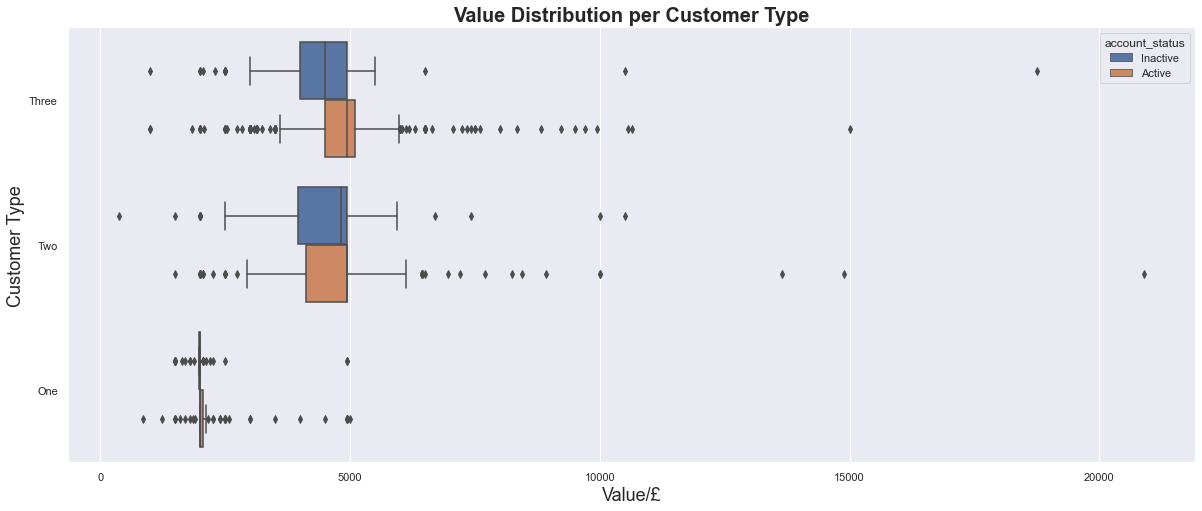

In [160]:
# Boxplot showing the distribution of value per customer type comparing both active and inactive clients

sns.set(rc={'figure.figsize':(18,8)}) 
ax = sns.boxplot(y=renewals['customer_type'], x=renewals['value'], hue = renewals['account_status'])
ax.set_title('Value Distribution per Customer Type', fontsize=20, weight='bold')
ax.set_xlabel('Value/£',fontsize=18)
ax.set_ylabel('Customer Type',fontsize=18);

This boxplot shows the average value for a small business's subscription is less than that of medium and large. Also, it shows the outliers we saw in the previous plot. Combining the information from both plots we can conclude the highest value is a medium sized business in year 1, and the second highest is a large corporation in year 1.

We can see from the above that the values for each element of the boxplot (first quartile, median, third quartile, minimum, maximum and outliers) of each customer type are lower for inactive clients than for active ones. 

Now let's look at client sectors.

In [40]:
# Creating a mask to make plotting easier

maskone = renewals.drop(columns=['customerid','customer_name','cancellation_reason','client_status','year_of_current_deal','customer_type'])

In [41]:
# Taking grouping steps on the mask to create a stacked plot

counts = maskone.groupby(['sector','account_status']).count()
print(counts)

                                  value
sector            account_status       
Charity           Active             52
                  Inactive           16
Consumer Finance  Active             14
                  Inactive            3
Consumer Products Active             20
                  Inactive            2
Education         Active             27
                  Inactive            6
Energy            Active              5
                  Inactive            3
Financials        Active            268
                  Inactive           47
Freelancer        Active             97
                  Inactive           44
General           Active            153
                  Inactive           63
Government Bodies Active             26
                  Inactive            4
Healthcare        Active             10
                  Inactive            3
Industry          Active             19
                  Inactive            6
Insurance         Active             19


In [42]:
# Step 2

counts = counts.unstack(level=1)
counts.columns = counts.columns.droplevel(level=0)
print (counts)

account_status     Active  Inactive
sector                             
Charity              52.0      16.0
Consumer Finance     14.0       3.0
Consumer Products    20.0       2.0
Education            27.0       6.0
Energy                5.0       3.0
Financials          268.0      47.0
Freelancer           97.0      44.0
General             153.0      63.0
Government Bodies    26.0       4.0
Healthcare           10.0       3.0
Industry             19.0       6.0
Insurance            19.0       2.0
Media                22.0       7.0
Mining                1.0       NaN
Property             29.0       5.0
Retailers            19.0      10.0
Support Services     30.0      11.0
Technology           17.0       7.0
Telecoms              5.0       1.0
Transport             8.0       1.0
Travel & Leisure     49.0      15.0
Utilities             5.0       NaN


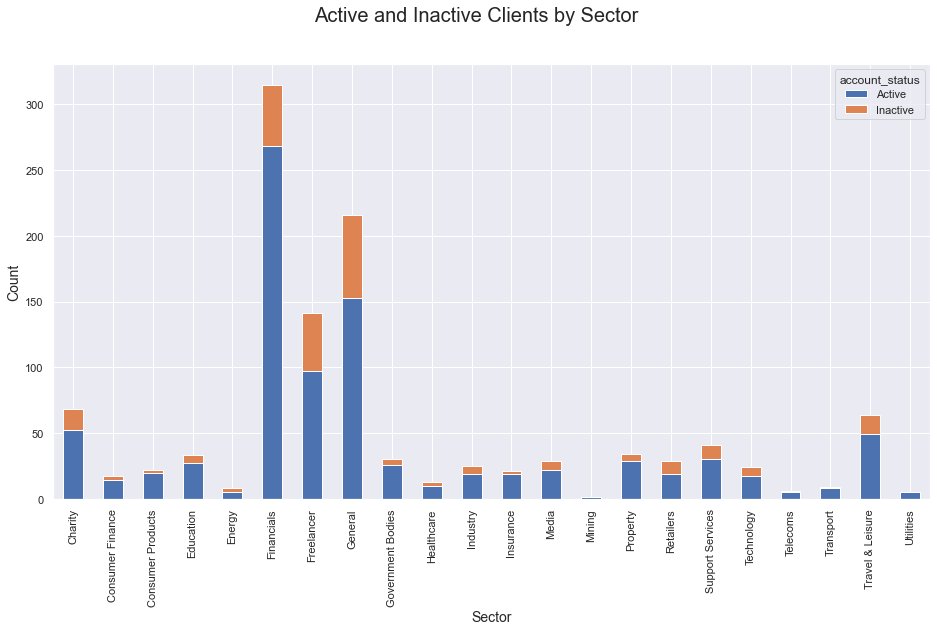

In [43]:
# A stacked bar chart of active and inactive clients by sector. 

counts.plot(kind ='bar', stacked = True, figsize = (14,8));
plt.xlabel('Sector', fontsize = 14);
plt.ylabel('Count', fontsize = 14);
plt.suptitle('Active and Inactive Clients by Sector', fontsize=20);  

Most of our clients sit within 4 sectors; financials, general, travel and leisure (consumer) and charity.

The plot shows the distribution of inactive and active clients in a sector. For example, general  has the highest percentage of cancelled clients. However, the number of cancelled clients in any one sector looks to increase as the number of live clients in the sector increases too. 

Our final datapoint to look at is the cancellation reason.

In [44]:
# Creating a mask to make plotting easier

masktwo = renewals.drop(columns=['customerid','customer_name','value','sector','client_status','customer_type'])

In [45]:
# Taking grouping steps on the mask to create a stacked plot

countstwo = masktwo.groupby(['year_of_current_deal', 'cancellation_reason']).count()
print(counts)

account_status     Active  Inactive
sector                             
Charity              52.0      16.0
Consumer Finance     14.0       3.0
Consumer Products    20.0       2.0
Education            27.0       6.0
Energy                5.0       3.0
Financials          268.0      47.0
Freelancer           97.0      44.0
General             153.0      63.0
Government Bodies    26.0       4.0
Healthcare           10.0       3.0
Industry             19.0       6.0
Insurance            19.0       2.0
Media                22.0       7.0
Mining                1.0       NaN
Property             29.0       5.0
Retailers            19.0      10.0
Support Services     30.0      11.0
Technology           17.0       7.0
Telecoms              5.0       1.0
Transport             8.0       1.0
Travel & Leisure     49.0      15.0
Utilities             5.0       NaN


In [46]:
# Step 2

countstwo = countstwo.unstack(level=1)
countstwo.columns = countstwo.columns.droplevel(level=0)
print (countstwo)

cancellation_reason   Data quality  Insufficient Funds  Low engagement  \
year_of_current_deal                                                     
1                             11.0                28.0             5.0   
2                              3.0                 5.0             NaN   
3                              NaN                 1.0             NaN   
4                              NaN                 NaN             NaN   
5                              NaN                 NaN             NaN   

cancellation_reason   Merged with exsisting client  No longer required  \
year_of_current_deal                                                     
1                                              3.0                95.0   
2                                              1.0                25.0   
3                                              NaN                 9.0   
4                                              NaN                 2.0   
5                                    

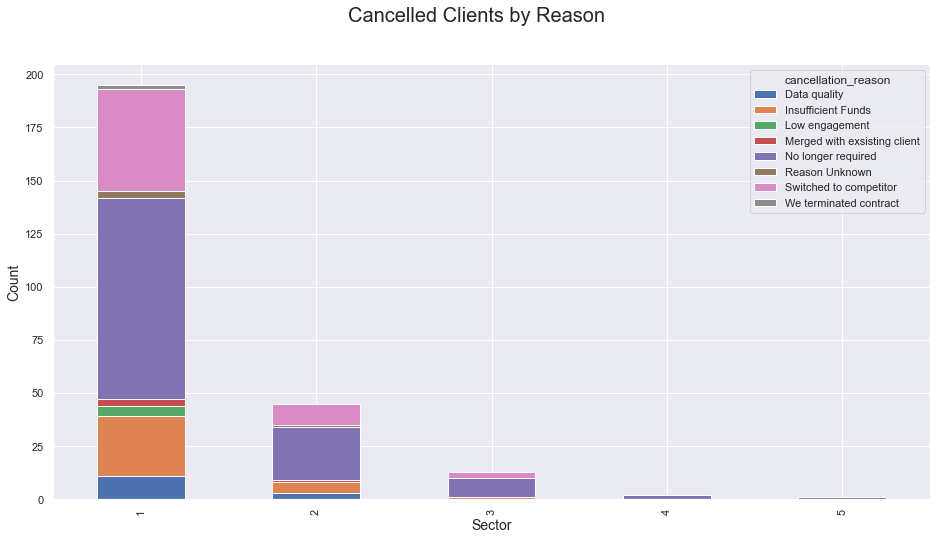

In [47]:
# A stacked bar chart to show cancellation reasons by years

countstwo.plot(kind ='bar', stacked = True, figsize = (14,8));
plt.xlabel('Year', fontsize = 14);
plt.ylabel('Count', fontsize = 14);
plt.suptitle('Cancelled Clients by Reason', fontsize=20);  

Here we can see clearly that the main reason clients cancel across all years is that the product is no longer required. Other reasons include going to competitors, budget and data gaps. This highlights an opportunity for us, if we are able to identify those clients that have little/no need and actively demonstrate to them during their subscription the value of our product with training and extra guidance from Account Managers, extra tips and content from marketing then we may be able to minimise nearly 50% of our cancelling clients in each year. 

# 4. Conclusion

To conclude, we have gained insights into both our live and cancelled clients, our cancellation rate is low at 22.2% of our entire client base. Whilst the account status given by Account Managers is subjective we know that cancelled clients more frequently have been 'mid' or 'low' engagement and usage at the time of their cancellation request. We have learnt that more clients cancel their subscriptions in year 1 than any other year, and once they have been subscribed for 3 years the data shows the likihood of them cancelling is closer to 0. In addition, our cancelled clients look to have less expensive subscription amounts. Most of our clients operate in the financial sector or are work generally across sectors and so are most of our cancellations in these areas also. Finally, when we consider the reason the client gave at the time of cancellation we know that 50% or more in each year state there is no longer a requirement for our service. Considering all of these insights I recommend that we review our current processes with the Account Managers with all of the above in mind, points to consider are: 

- Our onboarding process - Do we give enough training? Extra 1 on 1 sessions with people that will use it everyday (superusers). Or 'top up' training sessions throughout the subscription.
- First year check ins - Can we call first year clients more regularly to see how the subscription is going? This will enable Account Managers to gauge more of an idea of the interaction and change the client status as an indicator. 
- Marketing campaigns - Should we create a campaign for all first year users to drive top tips, short how to videos, alerts of new functionality to drive engagement?
- Our service desk - Should we prioritise our first year client incoming queries above others? This would ensure wait times for feedback are lower for first year clients.